# Disneyland Reviews


## Import Packages and Load Data

In [1]:
# imports
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt 

from PIL import Image
import imageio
from wordcloud import WordCloud,ImageColorGenerator

import spacy
from spacy import displacy
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
spacy.cli.download("en_core_web_md")
# load the language model, but we disable the ner (named entity recognition) and parser (dependency parser)
# since we don't need them for our use case to speed things up
nlp2 = spacy.load('en_core_web_md', disable = ['ner', 'parser'])
from scipy.spatial.distance import cosine

import re
import nltk 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from gensim.parsing.preprocessing import remove_stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer # TFID 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF
from sklearn.preprocessing import OneHotEncoder
ohe=OneHotEncoder()

!pip install textacy
import textacy
from textacy.preprocessing.replace import urls, hashtags, numbers, emails, emojis, currency_symbols
from textacy.preprocessing.normalize import quotation_marks, bullet_points
from textacy.preprocessing.remove import punctuation

from collections import Counter
from typing import List

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 25.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 requires numpy~=1.19.2, but you have numpy 1.21.6 which is incompatible.
tensorflow 2.6.4 requires tensorboard<2.7,>=2.6.0, but you have tensorboard 2.10.1 which is incompatible.
tensorflow 2.6.4 requires typing-extensions<3.11,>=3.7, but you have typing-extensions 4.1.1 which is incompatible.
tensorflow-transform 1.9.0 requires pyarrow<6,>=1, but you have pyarrow 8.0.0 which is incompatible.
tensorflow-transform 1.9.0 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<2.10,>=1.15.5, but you have tensorflow 2.6.4 which is incompatible.
tensorflow-serving-api 2.9.0 requires tensorflo

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 21.6 MB/s eta 0:00:00


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.4/200.4 kB 872.6 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 3.4 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 7.1 MB/s eta 0:00:00a 0:00:01
  Created wheel for jellyfish: filename=jellyfish-0.9.0-cp37-cp37m-linux_x86_64.whl size=102021 sha256=a7f5fd89cfeb7d43a4fd906520e986f5525502f3d8bf9b4e7263b110a82a69ee
  Stored in directory: /root/.cache/pip/wheels/fe/99/4e/646ce766df0d070b0ef04db27aa11543e2767fda3075aec31b
Successfully built jellyfish


In [2]:
# disney = pd.read_csv("../input/disneyland-reviews/DisneylandReviews.csv", encoding="latin-1")
disney = pd.read_csv("DisneylandReviews.csv", encoding='latin-1')

# Exploratory Data Analysis
- data cleaning
- data visualization

In [3]:
disney.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42656 entries, 0 to 42655
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Review_ID          42656 non-null  int64 
 1   Rating             42656 non-null  int64 
 2   Year_Month         42656 non-null  object
 3   Reviewer_Location  42656 non-null  object
 4   Review_Text        42656 non-null  object
 5   Branch             42656 non-null  object
dtypes: int64(2), object(4)
memory usage: 2.0+ MB


In [4]:
disney.drop(columns = ['Review_ID'], axis=1, inplace=True)

In [5]:
disney.head(3)

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,4,2019-4,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong
1,4,2019-5,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong
2,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong


In [6]:
disney.Year_Month.value_counts()

missing    2613
2015-8      786
2015-7      759
2015-12     701
2015-6      692
           ... 
2010-8        7
2010-5        4
2019-5        2
2010-3        2
2010-4        1
Name: Year_Month, Length: 112, dtype: int64

In [7]:
#timeserie feature
disney['Year_Month'].replace({'missing':np.nan}, inplace=True)
disney['Year_Month'] = pd.to_datetime(disney['Year_Month'].fillna(method='ffill'))
disney['Year_Month'].value_counts()

2015-08-01    786
2010-12-01    770
2015-07-01    760
2015-05-01    704
2015-12-01    701
             ... 
2010-08-01      7
2010-05-01      4
2019-05-01      2
2010-03-01      2
2010-04-01      1
Name: Year_Month, Length: 111, dtype: int64

In [8]:
disney['Year'] = disney['Year_Month'].dt.year
disney['Month'] = disney['Year_Month'].dt.month
disney.head()

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month
0,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4
1,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5
2,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4
3,4,2019-04-01,Australia,HK Disneyland is a great compact park. Unfortu...,Disneyland_HongKong,2019,4
4,4,2019-04-01,United Kingdom,"the location is not in the city, took around 1...",Disneyland_HongKong,2019,4


In [9]:
#drop duplicated records
print(disney['Review_Text'].duplicated().sum())
disney.drop_duplicates(subset='Review_Text', inplace=True)
disney['Review_Text'].duplicated().sum()

24


0

In [10]:
disney.Branch.unique()

array(['Disneyland_HongKong', 'Disneyland_California', 'Disneyland_Paris'],
      dtype=object)

In [11]:
disney.Reviewer_Location.unique()

array(['Australia', 'Philippines', 'United Arab Emirates',
       'United Kingdom', 'Singapore', 'India', 'Malaysia',
       'United States', 'Canada', 'Myanmar (Burma)', 'Hong Kong', 'China',
       'Indonesia', 'Qatar', 'New Zealand', 'Sri Lanka', 'Uganda',
       'Thailand', 'Austria', 'South Africa', 'Saudi Arabia', 'Japan',
       'Israel', 'South Korea', 'Turkey', 'Macau', 'Egypt', 'Mexico',
       'Mauritius', 'Sweden', 'Brazil', 'Kenya', 'Vietnam', 'Portugal',
       'Cambodia', 'Zambia', 'Croatia', 'France', 'Taiwan', 'Oman',
       'Colombia', 'Norway', 'Kuwait', 'Netherlands', 'Barbados',
       'Finland', 'Bosnia and Herzegovina', 'Brunei', 'Bahrain',
       'Maldives', 'Ireland', 'Russia', 'Romania',
       'Northern Mariana Islands', 'Germany', 'Chile', 'Isle of Man',
       'Pakistan', 'Ukraine', 'Greece', 'Switzerland', 'Spain', 'Estonia',
       "Côte d'Ivoire", 'Guam', 'Bangladesh', 'Belgium', 'Italy',
       'Botswana', 'Denmark', 'Argentina', 'Peru', 'Lithuania', 'I

Text(0.5, 1.0, 'Number of Rating By Year By Branch')

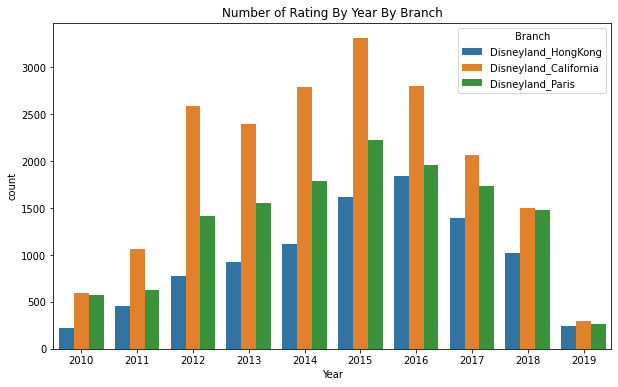

In [12]:
# number of rating by year and branch
plt.figure(figsize=(10,6))
ax=sns.countplot(data=disney,x='Year', hue ="Branch")
plt.title('Number of Rating By Year By Branch')

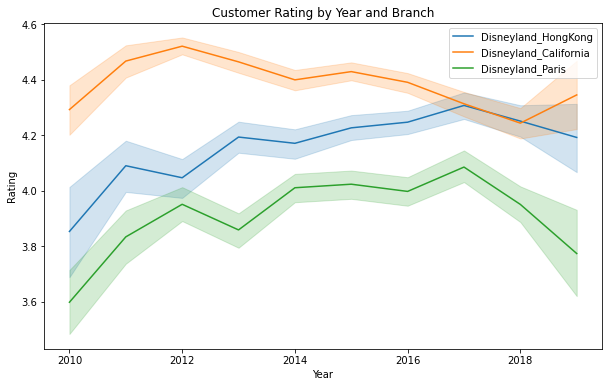

In [13]:
plt.figure(figsize=(10,6))
ax = sns.lineplot(data=disney,x='Year', y="Rating", hue ="Branch" )
plt.title("Customer Rating by Year and Branch")
plt.legend(loc='upper right')
plt.show()

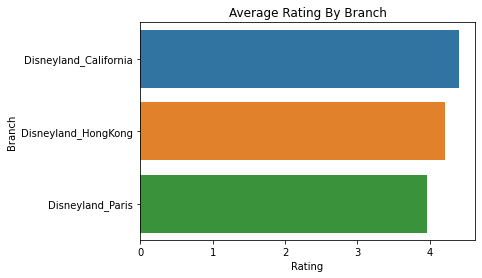

In [14]:
x = disney.groupby("Branch").mean().reset_index()
ax = sns.barplot(data = x,
            x = 'Rating', 
            y = "Branch")
plt.title("Average Rating By Branch")
plt.show()

In [15]:
disney.Rating.value_counts()/disney.shape[0]

5    0.542621
4    0.252580
3    0.119793
2    0.049845
1    0.035161
Name: Rating, dtype: float64

In [16]:
disney.Rating.value_counts()

5    23133
4    10768
3     5107
2     2125
1     1499
Name: Rating, dtype: int64

# Data Manipulation

- Regex + text manipulation

## Remove Stopword

In [17]:
#stopword removal
# setting to list, because we need to remove 'not'
stop_words = list(stopwords.words('english'))

# removing not from the list because we need to capture the sentiment when analyzing negative reviews
stop_words.remove('not')
#stop_words.append('really')
print(len(stop_words))


# stop_words = set(stopwords)
def remove_stopwords(text):
    new_text = ' '.join([word for word in nltk.word_tokenize(text) if word not in stop_words])
    return new_text

disney['new_review'] = [remove_stopwords(text) for text in disney['Review_Text']]

178


In [18]:
disney.head(3)

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month,new_review
0,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,If 've ever Disneyland anywhere 'll find Disne...
1,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,Its since last time visit HK Disneyland .. Yet...
2,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,Thanks God hot humid I visiting park otherwise...


In [19]:
# remove emojis, urls, hashtags, and etc.
disney['new_review'] = disney['new_review'].\
 apply(urls).\
 apply(hashtags).\
 apply(currency_symbols).\
 apply(emojis).\
 apply(emails).\
 apply(punctuation)

In [20]:
disney['new_review'] = disney['new_review'].str.replace(r'\b(\d+\w+)\b','',regex=True)

In [21]:
#regex cleaning - add more regex to the function
def regex(review):
    # lowercase
#     review = " ".join(x.lower() for x in review.split())
    
    
    #clean disneyland, disney park
    review = re.sub(r'\b(disney(?:land| park|park|paris)|park|disney)\b',"DISNEY", review,flags = re.IGNORECASE)
    #clean any disney location
    review = re.sub(r'\b(hk|hong(?: kong|kong)|la|los angeles|ca|california|anaheim|tokyo|japan|florida｜australia|united states|usa|france|shang(?: hai|hai)|china|paris)\b',"LOCATION",review,flags = re.IGNORECASE)
    #clean any holidays
    review = re.sub(r'\b(christmas|(?:chirst|x)mas)|anniversa(?:ry|ries)|b(?:-?day|irthdays?)|v(?:-?day|alentines day|alentines)|new years?|holidays?|weddings?|thanksgivings?\b','HOLIDAY', review,flags = re.IGNORECASE)
    #clean visitor
    review = re.sub(r'\b((?:(\-)?\d+ years?(\-| ))?old child(?:ren))|children|kids?|grand(?:kids?|sons?|fathers?|daughters?|dad|mom|ma|pa)|(?:boy|girl)friends?\b','VISITOR',review,flags = re.IGNORECASE)
    review = re.sub(r'\bbig\s*thunder\s*mountain\b',"Big_Thunder_Mountain",review,flags = re.IGNORECASE)
    review =  re.sub(r'\bindiana\s*(jone|jones)(\s*(ride|rides))?\b',"Indiana_Jones_Ride",review,flags = re.IGNORECASE)
    review =  re.sub(r'\blion\s*(king|kings)(\s*(show|shows))?\b',"Lion_King_Show",review,flags = re.IGNORECASE)
    review =  re.sub(r'\b(fas|fast)\s*pas+(\ssystem)?\b',"Fast_Pass",review,flags = re.IGNORECASE)

    #replace disney location, location disney, walt disney.. with DISNEY token
    review =  re.sub(r'\b(disney|location|walt)\s*(location|disney|world)\s*(world)?\b',"DISNEY",review,flags = re.IGNORECASE)
    review = re.sub(r'\b(hk|hong(?: kong|kong)|la|los angeles|ca|california|anaheim|tokyo|japan|florida|orlando|australia|united states|usa|france|shang(?: hai|hai)|china|paris)\b',"LOCATION",review,flags = re.IGNORECASE)
    
    
    # my regex
    review = re.sub(r'\b(n|t|u|s)\b','',review,flags = re.IGNORECASE)

    
    return review
disney['new_review'] =[regex(review) for review in disney['new_review']]

## Lemmatization

In [22]:
#Lemmatization
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [23]:
lemmatizer = WordNetLemmatizer()

# the code below is from https://gist.github.com/gaurav5430/9fce93759eb2f6b1697883c3782f30de :)
# function to convert nltk tag to wordnet tag
def nltk_tag_to_wordnet_tag(nltk_tag):
    if nltk_tag.startswith('J'):
        return wordnet.ADJ
    elif nltk_tag.startswith('V'):
        return wordnet.VERB
    elif nltk_tag.startswith('N'):
        return wordnet.NOUN
    elif nltk_tag.startswith('R'):
        return wordnet.ADV
    else:         
        return None

def lemmatize_sentence(sentence):
    #tokenize the sentence and find the POS tag for each token
    nltk_tagged = nltk.pos_tag(nltk.word_tokenize(sentence)) 
    #tuple of (token, wordnet_tag)
    wordnet_tagged = map(lambda x: (x[0], nltk_tag_to_wordnet_tag(x[1])), nltk_tagged)
    lemmatized_sentence = []
    for word, tag in wordnet_tagged:
        if tag is None:
            #if there is no available tag, append the token as is
            lemmatized_sentence.append(word)
        else:       
            #else use the tag to lemmatize the token
            lemmatized_sentence.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_sentence)

disney['new_review'] = disney['new_review'].apply(lemmatize_sentence) 

## Vectorization

In [24]:
nlp = spacy.load("en_core_web_md")

def vectorize(df, i):
    vectorizer = TfidfVectorizer(max_features=2000, ngram_range=(i,i),stop_words=['ve','ll','d'])
    XtfidfFit, features = vectorizer.fit_transform(df['new_review']), vectorizer.get_feature_names()
    x_tf_idf = pd.DataFrame(XtfidfFit.toarray(), columns=features)
    print('complete-tf-idf')
    
    vectorizer = CountVectorizer(max_features=2000, ngram_range=(i,i), stop_words=['ve','ll','d'])
    XcountFit, features = vectorizer.fit_transform(df['new_review']), vectorizer.get_feature_names()
    x_countVect = pd.DataFrame(XcountFit.toarray(), columns=features)
    print('complete-countvect')

    df['vector'] = df['new_review'].apply(lambda x: nlp(x).vector)
    x_wordvec = np.array([vector for vector in df["vector"]])
    print('complete-wordvec')


    return x_tf_idf,XtfidfFit,x_countVect,XcountFit,x_wordvec

xtfidf, xtfidfFit, xcountvec, xcountFit,x_wordvec = vectorize(disney, 1) #, xwordvec   

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


complete-tf-idf
complete-countvect
complete-wordvec


## Positive/Negative

In [25]:
#create new columns from ratings for future analysis
mapping = {4:'Neutral',5:'Positive',1:'Negative',2:'Negative',3:'Negative'}
mapping2 = {4:0,5:1,1:-1,2:-1,3:-1}

disney['posneg'] = disney['Rating'].apply(lambda x: mapping[x])
disney['posneg_Encode'] = disney['Rating'].apply(lambda x: mapping2[x])
disney.head(3)

,Rating,Year_Month,Reviewer_Location,Review_Text,Branch,Year,Month,new_review,vector,posneg,posneg_Encode
0,4,2019-04-01,Australia,If you've ever been to Disneyland anywhere you...,Disneyland_HongKong,2019,4,If ve ever DISNEY anywhere ll find DISNEYsimil...,"[-0.6671483, 0.14743593, -0.1877167, 0.0373555...",Neutral,0
1,4,2019-05-01,Philippines,Its been a while since d last time we visit HK...,Disneyland_HongKong,2019,5,Its since last time visit DISNEYYet time stay ...,"[-0.69758564, 0.14517999, -0.11615663, -0.1124...",Neutral,0
2,4,2019-04-01,United Arab Emirates,Thanks God it wasn t too hot or too humid wh...,Disneyland_HongKong,2019,4,Thanks God hot humid I visit DISNEY otherwise ...,"[-0.70406127, 0.14274883, -0.18517499, -0.0818...",Neutral,0


# WordCloud

In [26]:
def wordCloudGenerator(words,pic,name):
    img = imageio.imread(pic) 

    wc = WordCloud(
        mask=img,
        background_color="white",
        max_font_size=500,  
        random_state=42,
        prefer_horizontal=1.0,
        max_words=200,
        scale=4
    ).generate(words)
    
    # color
    bimgColors = ImageColorGenerator(img)
    
    # show graph
    plt.imshow(wc.recolor(color_func=bimgColors))
    plt.axis("off")
    plt.show()
    
    # save graph
    wc.to_file(name+'.png')    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


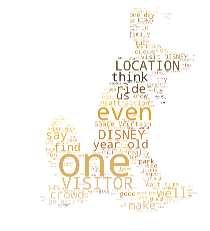

In [27]:
# words = []
# for i in disney['new_review']:
#     _ = i.split(' ')
#     for i in _:
#         if i in newStopWords:
#             pass
#         else:
#             words.append(i)

words1 = ' '.join(list(disney['new_review']))
# pic1 = '/kaggle/input/mydisney/mickey_mouse_PNG99.png'
pic1 = './mydisney/mickey_mouse_PNG99.png'
name1 = 'Overview'

wordCloudGenerator(words1,pic1,name1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


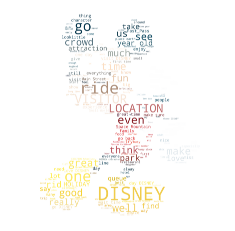

In [28]:
words2 = ' '.join(list(disney[disney['posneg']=='Positive']['new_review']))
# pic2 = '/kaggle/input/mydisney/mickey_mouse_PNG76.png'
pic2 = './mydisney/mickey_mouse_PNG76.png'
name2 = 'Positive'

wordCloudGenerator(words2,pic2,name2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


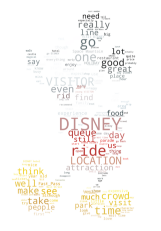

In [29]:
# words3 = []
# for i in disney[disney['posneg']=='Neutral']['new_review']:
#     _ = i.split(' ')
#     for i in _:
#         if i in newStopWords:
#             pass
#         else:
#             words3.append(i)
# words3 = ' '.join(words3)

            
words3 = ' '.join(list(disney[disney['posneg']=='Neutral']['new_review']))
# pic3 = '/kaggle/input/mydisney/mickey_mouse_PNG79.png'
pic3 = './mydisney/mickey_mouse_PNG79.png'
name3 = 'Neutral'

wordCloudGenerator(words3,pic3,name3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  


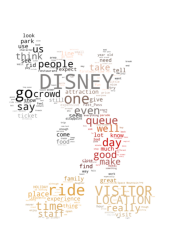

In [30]:
words4 = ' '.join(list(disney[disney['posneg']=='Negative']['new_review']))
# pic4 = '/kaggle/input/mydisney/mickey_mouse_PNG97.png'
pic4 = './mydisney/mickey_mouse_PNG97.png'

name4 = 'Negative'

wordCloudGenerator(words4,pic4,name4)

# Topic Modeling

## Data Preparation

In [31]:
disney.index = [i for i in range(0,len(disney))]

In [32]:
# to get word vector with n_gram=3
xtfidf, xtfidfFit, xcountvec, xcountFit,x_wordvec = vectorize(disney, 3) #, xwordvec

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


complete-tf-idf
complete-countvect
complete-wordvec


In [33]:
# to get the list of positive negative neutral ratings index for it to run the vectorization & topic modeling later
neg_index = disney.loc[disney['posneg']=='Negative'].index
pos_index = disney.loc[disney['posneg']=='Positive'].index
neutral_index = disney.loc[disney['posneg']=='Neutral'].index

# filter out all the documents for reviews according to different rating level in the vectorized matrix
neg_tfidf=xtfidf.iloc[neg_index]
neg_countvec= xcountvec.iloc[neg_index]

pos_tfidf=xtfidf.iloc[pos_index]
pos_countvec= xcountvec.iloc[pos_index]  

neutral_tfidf=xtfidf.iloc[neutral_index]
neutral_countvec= xcountvec.iloc[neutral_index]

In [34]:
# to get the list of different branch and different rating index for it to run the vectorization & topic modeling later
hk_index = disney.loc[disney['Branch']=='Disneyland_HongKong'].index
hk_neg_index = disney.loc[(disney['posneg']=='Negative') & (disney['Branch']=='Disneyland_HongKong')].index
hk_pos_index = disney.loc[(disney['posneg']=='Positive') & (disney['Branch']=='Disneyland_HongKong')].index
hk_neutral_index = disney.loc[(disney['posneg']=='Neutral') & (disney['Branch']=='Disneyland_HongKong')].index


ca_index = disney.loc[disney['Branch']=='Disneyland_California'].index
ca_neg_index = disney.loc[(disney['posneg']=='Negative') & (disney['Branch']=='Disneyland_California')].index
ca_pos_index = disney.loc[(disney['posneg']=='Positive') & (disney['Branch']=='Disneyland_California')].index
ca_neutral_index = disney.loc[(disney['posneg']=='Neutral') & (disney['Branch']=='Disneyland_California')].index


pr_index = disney.loc[disney['Branch']=='Disneyland_Paris'].index
pr_neg_index = disney.loc[(disney['posneg']=='Negative') & (disney['Branch']=='Disneyland_Paris')].index
pr_pos_index = disney.loc[(disney['posneg']=='Positive') & (disney['Branch']=='Disneyland_Paris')].index
pr_neutral_index = disney.loc[(disney['posneg']=='Neutral') & (disney['Branch']=='Disneyland_Paris')].index

In [35]:
len(hk_pos_index)

4511

In [36]:
# filter out all the documents for reviews according to different branch in the vectorized matrix
hk_tfidf=xtfidf.iloc[hk_index]
hk_countvec= xcountvec.iloc[hk_index]
hk_neg_tfidf=xtfidf.iloc[hk_neg_index]
hk_neg_countvec= xcountvec.iloc[hk_neg_index]
hk_pos_tfidf=xtfidf.iloc[hk_pos_index]
hk_pos_countvec= xcountvec.iloc[hk_pos_index]
hk_neutral_tfidf=xtfidf.iloc[hk_neutral_index]
hk_neutral_countvec= xcountvec.iloc[hk_neutral_index]

ca_tfidf=xtfidf.iloc[ca_index]
ca_countvec= xcountvec.iloc[ca_index]
ca_neg_tfidf=xtfidf.iloc[ca_neg_index]
ca_neg_countvec= xcountvec.iloc[ca_neg_index]
ca_pos_tfidf=xtfidf.iloc[ca_pos_index]
ca_pos_countvec= xcountvec.iloc[ca_pos_index]
ca_neutral_tfidf=xtfidf.iloc[ca_neutral_index]
ca_neutral_countvec= xcountvec.iloc[ca_neutral_index]

pr_tfidf=xtfidf.iloc[pr_index]
pr_countvec= xcountvec.iloc[pr_index]
pr_neg_tfidf=xtfidf.iloc[pr_neg_index]
pr_neg_countvec= xcountvec.iloc[pr_neg_index]
pr_pos_tfidf=xtfidf.iloc[pr_pos_index]
pr_pos_countvec= xcountvec.iloc[pr_pos_index]
pr_neutral_tfidf=xtfidf.iloc[pr_neutral_index]
pr_neutral_countvec= xcountvec.iloc[pr_neutral_index]

## Define Functions

In [37]:
# define function to get tokens for topic
def get_top_tf_idf_tokens_for_topic(H: np.array, feature_names: List[str], num_top_tokens: int = 5):
  """
  Uses the H matrix (K components x M original features) to identify for each
  topic the most frequent tokens.
  """
  for topic, vector in enumerate(H):
    print(f"TOPIC {topic}\n")
    total = vector.sum()
    top_scores = vector.argsort()[::-1][:num_top_tokens]
    token_names = list(map(lambda idx: feature_names[idx], top_scores))
    strengths = list(map(lambda idx: vector[idx] / total, top_scores))
    
    for strength, token_name in zip(strengths, token_names):
        print(f"\b{token_name} ({round(strength * 100, 1)}%)\n")
    print(f"=" * 50)

In [38]:
# define function to get top documents for each topic
def get_top_documents_for_each_topic(W: np.array, documents: List[str], num_docs: int = 5):
    sorted_docs = W.argsort(axis=0)[::-1]
    top_docs = sorted_docs[:num_docs].T
    per_document_totals = W.sum(axis=1)
    for topic, top_documents_for_topic in enumerate(top_docs):
        print(f"Topic {topic}")
        for doc in top_documents_for_topic:
            score = W[doc][topic]   
            percent_about_topic = round(score / per_document_totals[doc] * 100, 1)
            print(f"{percent_about_topic}%", documents[doc])
            print("=" * 50)

## TFIDF for All Reviews

In [39]:
# fit NMF model for topic number = 3-6 for negative review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(neg_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

# n=6: cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low.
# n=5: cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low. 
# n=4: Better grouping and can see different topics. 

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (24.2%)

not happy place (4.3%)

disney happy place (1.8%)

the happy place (1.2%)

place earth the (0.9%)

TOPIC 1

character walk around (8.0%)

walk around disney (4.3%)

disney character walk (2.9%)

many ride close (2.1%)

not worth money (0.9%)

TOPIC 2

save money go (19.0%)

money go location (8.2%)

go ocean disney (3.1%)

disney land location (1.0%)

the disney not (0.7%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (24.1%)

not happy place (4.3%)

disney happy place (1.7%)

the happy place (1.2%)

place earth the (0.9%)

TOPIC 1

character walk around (10.7%)

walk around disney (5.6%)

disney character walk (3.8%)

not worth money (1.1%)

see character walk (1.0%)

TOPIC 2

save money go (18.8%)

money go location (8.1%)

go ocean disney (3.1%)

disney land location (1.1%)

the disney not (0.7%)

TOPIC 3

many ride close (14.9%)

ride close refurbishment (1.9%)

ride close due (1.7%)

it small world (1.6%)

waste time money (1.4%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (24.6%)

not happy place (4.4%)

disney happy place (1.8%)

the happy place (1.2%)

place earth the (0.9%)

TOPIC 1

character walk around (11.4%)

walk around disney (6.0%)

disney character walk (4.0%)

see character walk (1.0%)

see disney character (1.0%)

TOPIC 2

save money go (19.0%)

money go location (8.2%)

go ocean disney (3.1%)

disney land location (1.0%)

the disney not (0.7%)

TOPIC 3

many ride close (15.2%)

ride close refurbishment (1.9%)

ride close due (1.7%)

it small world (1.6%)

waste time money (1.4%)

TOPIC 4

not worth money (25.7%)

it not worth (3.0%)

disney land location (1.7%)

disney theme disney (1.4%)

ride space mountain (1.2%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (28.8%)

not happy place (5.1%)

disney happy place (2.1%)

the happy place (1.4%)

place earth the (1.1%)

TOPIC 1

character walk around (14.8%)

walk around disney (7.7%)

disney character walk (5.3%)

see character walk (1.4%)

see disney character (1.3%)

TOPIC 2

save money go (23.5%)

money go location (10.2%)

go ocean disney (3.8%)

disney land location (1.2%)

go disney location (0.8%)

TOPIC 3

many ride close (23.0%)

ride close refurbishment (2.8%)

ride close due (2.5%)

close due technical (1.6%)

waste time money (1.5%)

TOPIC 4

not worth money (33.1%)

it not worth (3.7%)

disney land location (2.1%)

disney theme disney (1.7%)

ride space mountain (1.4%)

TOPIC 5

it small world (4.8%)

never go back (4.7%)

not go back (2.0%)

would never go (1.3%)

would not go (1.3%)



In [40]:
nmf = NMF(n_components=4)
W = nmf.fit_transform(neg_tfidf)
get_top_documents_for_each_topic(W, disney['new_review'].tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 0
100.0% grandVISITOR meet STARS Princesses Cinderella couple Frozens Pooh Bear Dumbo Mickey Mouse whole Club M O E parent laugh pay grand parent revel fun ride FOOD WAS ok FOR THE PLACE AND TIME spend 5 hour 3 5 yo enough Everybody fun despite occasional shower wet underfoot ride Take light cape case We drive big carpark good time You take MTR direct DISNEY take extra money merchandise bribe good behaviour leave get yummy sweet popcorn 4 type separate seal bag Ask steam train want not properly work schedule
100.0% This second visit three year standard drop little The ride still cafe serf average food gift store longer sell quality gift Very average thing sale disappoint expensive item like ornament longer sale You not get decent coffee The place small one day plenty time What I find annoy offer cheap deal people Asia country not get discount In LOCATION would class racist discriminate people I contact management I think unfair give discount certain people not others The VISITOR 

In [41]:
# fit NMF model for topic number = 3-6 for positive review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(pos_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (27.1%)

truly happy place (3.5%)

the happy place (3.0%)

really happy place (2.9%)

disney happy place (2.5%)

TOPIC 1

wait go back (13.3%)

location wait go (12.2%)

cant wait go (1.2%)

not wait go (1.2%)

we great time (1.0%)

TOPIC 2

happiest place earth (21.1%)

dream come true (4.6%)

the happiest place (3.5%)

it small world (1.0%)

place earth the (0.6%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (27.5%)

truly happy place (3.6%)

the happy place (3.0%)

really happy place (2.9%)

disney happy place (2.5%)

TOPIC 1

wait go back (13.6%)

location wait go (12.5%)

cant wait go (1.2%)

not wait go (1.2%)

we great time (1.0%)

TOPIC 2

happiest place earth (25.9%)

the happiest place (4.3%)

it small world (1.0%)

place earth the (0.7%)

place earth we (0.6%)

TOPIC 3

dream come true (26.1%)

it small world (1.0%)

stay disney hotel (1.0%)

year old daughter (0.8%)

we spend day (0.6%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (29.0%)

truly happy place (3.8%)

the happy place (3.2%)

really happy place (3.1%)

disney happy place (2.7%)

TOPIC 1

wait go back (16.1%)

location wait go (14.8%)

cant wait go (1.4%)

not wait go (1.4%)

we location wait (0.9%)

TOPIC 2

happiest place earth (29.5%)

the happiest place (4.9%)

place earth the (0.8%)

place earth we (0.7%)

place earth it (0.6%)

TOPIC 3

dream come true (32.1%)

stay disney hotel (0.9%)

year old daughter (0.7%)

there much see (0.5%)

visitor adult alike (0.5%)

TOPIC 4

we great time (11.3%)

it small world (2.5%)

great time disney (1.9%)

year old daughter (1.0%)

stay disney hotel (0.9%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (31.4%)

truly happy place (4.1%)

the happy place (3.5%)

really happy place (3.4%)

disney happy place (2.9%)

TOPIC 1

wait go back (19.3%)

location wait go (17.7%)

cant wait go (1.7%)

not wait go (1.7%)

we location wait (1.1%)

TOPIC 2

happiest place earth (36.2%)

the happiest place (6.0%)

place earth the (1.0%)

place earth we (0.9%)

place earth it (0.8%)

TOPIC 3

dream come true (41.8%)

visitor adult alike (0.6%)

there much see (0.6%)

meet disney character (0.5%)

sleep beauty castle (0.5%)

TOPIC 4

we great time (29.3%)

great time disney (4.7%)

great time we (1.5%)

had great time (1.5%)

we spend day (1.1%)

TOPIC 5

it small world (5.2%)

stay disney hotel (1.5%)

year old daughter (1.3%)

worth every penny (1.1%)

day disney hopper (0.8%)



In [42]:
# fit NMF model for topic number = 3-6 for neutral review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(neutral_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)
    

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

it small world (16.5%)

small world ride (2.1%)

small world close (1.1%)

like it small (0.9%)

location adventure disney (0.9%)

TOPIC 1

toy story land (17.5%)

grizzly gulch mystic (1.3%)

ride toy story (1.2%)

big grizzly mountain (1.1%)

like space mountain (0.9%)

TOPIC 2

stay disney hotel (5.8%)

happy place earth (2.1%)

we stay disney (1.6%)

if stay disney (1.1%)

disney hotel get (1.0%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

it small world (15.8%)

small world ride (2.0%)

small world close (1.0%)

location adventure disney (0.9%)

like it small (0.9%)

TOPIC 1

toy story land (16.8%)

grizzly gulch mystic (1.2%)

ride toy story (1.1%)

big grizzly mountain (1.0%)

like space mountain (0.8%)

TOPIC 2

stay disney hotel (7.8%)

we stay disney (2.1%)

if stay disney (1.5%)

disney hotel get (1.4%)

year old daughter (0.9%)

TOPIC 3

happy place earth (15.9%)

disney happy place (2.1%)

one happy place (1.2%)

say happy place (1.2%)

place earth it (1.1%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

it small world (21.0%)

small world ride (2.6%)

small world close (1.3%)

like it small (1.2%)

ride it small (1.1%)

TOPIC 1

toy story land (22.4%)

grizzly gulch mystic (1.7%)

ride toy story (1.5%)

big grizzly mountain (1.2%)

like space mountain (1.0%)

TOPIC 2

stay disney hotel (15.8%)

we stay disney (4.2%)

if stay disney (3.0%)

disney hotel get (2.8%)

extra magic hour (1.2%)

TOPIC 3

happy place earth (23.6%)

disney happy place (3.1%)

one happy place (1.8%)

say happy place (1.8%)

place earth it (1.6%)

TOPIC 4

year old daughter (2.1%)

we great time (1.8%)

get fast pass (1.4%)

we visit disney (1.1%)

my year old (1.0%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

it small world (20.0%)

small world ride (2.5%)

small world close (1.3%)

like it small (1.1%)

ride it small (1.1%)

TOPIC 1

toy story land (21.4%)

grizzly gulch mystic (1.6%)

ride toy story (1.4%)

big grizzly mountain (1.2%)

like space mountain (1.0%)

TOPIC 2

stay disney hotel (14.8%)

we stay disney (4.0%)

if stay disney (2.8%)

disney hotel get (2.6%)

extra magic hour (1.2%)

TOPIC 3

happy place earth (23.0%)

disney happy place (3.1%)

one happy place (1.8%)

say happy place (1.8%)

place earth it (1.5%)

TOPIC 4

we great time (3.5%)

get fast pass (2.3%)

we visit disney (1.4%)

great time disney (1.4%)

first time disney (1.2%)

TOPIC 5

year old daughter (10.8%)

my year old (4.5%)

year old son (2.8%)

year old visitor (1.9%)

old daughter love (1.3%)



## Countvec for All Reviews

In [43]:
# fit NMF model for topic number = 3-5 for negative review, countvec
for i in range(3,6):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(neg_countvec)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

cur cur cur (58.1%)

time last year (2.5%)

get fast pass (1.6%)

peter pan ride (1.4%)

wait long line (1.3%)

TOPIC 1

happy place earth (19.6%)

not happy place (3.7%)

the happy place (1.2%)

disney happy place (1.1%)

day disney hopper (1.0%)

TOPIC 2

stay disney hotel (2.8%)

character walk around (2.2%)

walk around disney (1.7%)

it small world (1.4%)

year old daughter (0.9%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

cur cur cur (57.6%)

time last year (2.5%)

get fast pass (1.6%)

peter pan ride (1.4%)

wait long line (1.3%)

TOPIC 1

happy place earth (18.6%)

not happy place (3.6%)

the happy place (1.2%)

disney happy place (1.1%)

day disney hopper (1.0%)

TOPIC 2

stay disney hotel (4.7%)

it small world (2.1%)

year old daughter (1.1%)

we stay disney (0.9%)

peter pan ride (0.8%)

TOPIC 3

character walk around (9.7%)

walk around disney (6.9%)

disney character walk (3.6%)

see character walk (1.2%)

see disney character (0.8%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

cur cur cur (58.7%)

time last year (2.5%)

get fast pass (1.6%)

peter pan ride (1.3%)

wait long line (1.3%)

TOPIC 1

happy place earth (21.0%)

not happy place (4.0%)

the happy place (1.3%)

disney happy place (1.2%)

place earth not (1.0%)

TOPIC 2

stay disney hotel (13.0%)

we stay disney (2.3%)

extra magic hour (1.6%)

extra magic hours (1.3%)

not stay disney (1.3%)

TOPIC 3

character walk around (10.8%)

walk around disney (7.6%)

disney character walk (4.0%)

see character walk (1.4%)

see disney character (1.0%)

TOPIC 4

it small world (4.3%)

year old daughter (1.6%)

day disney hopper (1.1%)

go back hotel (0.9%)

peter pan ride (0.9%)



In [44]:
# fit NMF model for topic number = 3-5 for positive review, countvec
for i in range(3,6):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(pos_countvec)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (28.6%)

truly happy place (3.6%)

really happy place (2.9%)

the happy place (2.2%)

disney happy place (1.7%)

TOPIC 1

wait go back (15.1%)

location wait go (13.4%)

year old daughter (1.0%)

cant wait go (1.0%)

time location wait (1.0%)

TOPIC 2

it small world (3.8%)

day disney hopper (1.5%)

stay disney hotel (1.4%)

year old daughter (0.7%)

sleeping beauty castle (0.6%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (29.4%)

truly happy place (3.7%)

really happy place (2.9%)

the happy place (2.3%)

disney happy place (1.7%)

TOPIC 1

wait go back (14.6%)

location wait go (13.0%)

year old daughter (1.1%)

cant wait go (1.0%)

time location wait (0.9%)

TOPIC 2

it small world (6.2%)

stay disney hotel (2.0%)

toy story land (1.0%)

sleeping beauty castle (0.9%)

small world ride (0.8%)

TOPIC 3

day disney hopper (6.7%)

disney hopper pas (2.4%)

disney hopper ticket (1.9%)

location adventure disney (1.6%)

we day disney (1.1%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (29.4%)

truly happy place (3.7%)

really happy place (2.9%)

the happy place (2.3%)

disney happy place (1.7%)

TOPIC 1

wait go back (15.1%)

location wait go (13.4%)

year old daughter (1.0%)

cant wait go (1.0%)

time location wait (1.0%)

TOPIC 2

it small world (9.1%)

small world ride (1.2%)

sleeping beauty castle (1.1%)

toy story land (1.1%)

ride space mountain (0.8%)

TOPIC 3

day disney hopper (6.6%)

disney hopper pas (2.3%)

disney hopper ticket (1.8%)

location adventure disney (1.6%)

we day disney (1.1%)

TOPIC 4

stay disney hotel (9.2%)

we stay disney (1.9%)

year old daughter (1.4%)

disney hotel get (1.4%)

if stay disney (1.2%)



In [45]:
# fit NMF model for topic number = 3-5 for neutral review, countvec
for i in range(3,6):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(neutral_countvec)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

it small world (11.7%)

small world ride (1.2%)

sleeping beauty castle (1.1%)

location adventure disney (0.9%)

peter pan flight (0.7%)

TOPIC 1

stay disney hotel (7.7%)

we stay disney (1.5%)

disney hotel get (1.3%)

if stay disney (1.3%)

extra magic hour (1.2%)

TOPIC 2

toy story land (7.7%)

happy place earth (1.8%)

big grizzly mountain (1.5%)

grizzly mountain runaway (1.2%)

mountain runaway mine (1.2%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

it small world (14.6%)

small world ride (1.5%)

sleeping beauty castle (1.3%)

like it small (0.8%)

peter pan flight (0.8%)

TOPIC 1

stay disney hotel (12.5%)

we stay disney (2.4%)

disney hotel get (2.2%)

if stay disney (2.1%)

extra magic hour (1.4%)

TOPIC 2

toy story land (11.6%)

big grizzly mountain (2.1%)

grizzly mountain runaway (1.8%)

mountain runaway mine (1.7%)

runaway mine cars (1.6%)

TOPIC 3

day disney hopper (2.5%)

get fast pass (2.4%)

happy place earth (1.9%)

location adventure disney (1.6%)

disney hopper ticket (1.1%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

it small world (14.7%)

small world ride (1.5%)

sleeping beauty castle (1.3%)

like it small (0.8%)

peter pan flight (0.8%)

TOPIC 1

stay disney hotel (12.7%)

we stay disney (2.4%)

disney hotel get (2.2%)

if stay disney (2.1%)

extra magic hour (1.4%)

TOPIC 2

toy story land (11.5%)

big grizzly mountain (2.1%)

grizzly mountain runaway (1.8%)

mountain runaway mine (1.7%)

runaway mine cars (1.5%)

TOPIC 3

day disney hopper (2.8%)

get fast pass (2.7%)

location adventure disney (1.8%)

disney hopper ticket (1.3%)

we great time (1.0%)

TOPIC 4

happy place earth (18.5%)

disney happy place (1.8%)

one happy place (1.5%)

truly happy place (1.0%)

place earth it (0.9%)



## TFIDF for Different Branch

### Hong Kong

In [46]:
#fit NMF model for hk review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(hk_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

# cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low. 

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (27.2%)

ride toy story (2.1%)

love toy story (1.3%)

grizzly gulch mystic (1.2%)

the toy story (0.9%)

TOPIC 1

big grizzly mountain (6.5%)

grizzly mountain runaway (4.7%)

mountain runaway mine (4.5%)

runaway mine cars (3.9%)

iron man experience (2.8%)

TOPIC 2

spend whole day (30.3%)

we spend whole (4.1%)

whole day disney (3.8%)

dream come true (3.3%)

must visit place (1.8%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (27.4%)

ride toy story (2.1%)

love toy story (1.3%)

grizzly gulch mystic (1.2%)

the toy story (0.9%)

TOPIC 1

big grizzly mountain (7.4%)

grizzly mountain runaway (5.3%)

mountain runaway mine (5.1%)

runaway mine cars (4.4%)

iron man experience (3.0%)

TOPIC 2

spend whole day (33.9%)

we spend whole (4.6%)

whole day disney (4.2%)

must visit place (2.0%)

not big disney (1.2%)

TOPIC 3

day not enough (10.3%)

one day not (7.8%)

go ocean disney (5.4%)

dream come true (4.7%)

happy place earth (3.3%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (27.4%)

ride toy story (2.1%)

love toy story (1.3%)

grizzly gulch mystic (1.2%)

the toy story (0.9%)

TOPIC 1

big grizzly mountain (7.4%)

grizzly mountain runaway (5.3%)

mountain runaway mine (5.1%)

runaway mine cars (4.4%)

iron man experience (3.0%)

TOPIC 2

spend whole day (33.7%)

we spend whole (4.5%)

whole day disney (4.2%)

must visit place (1.9%)

not big disney (1.2%)

TOPIC 3

day not enough (12.9%)

one day not (9.8%)

dream come true (5.7%)

happy place earth (3.9%)

golden mickey show (0.9%)

TOPIC 4

go ocean disney (32.1%)

the disney small (2.6%)

save money go (1.6%)

much small disney (1.2%)

it much small (1.2%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (27.4%)

ride toy story (2.1%)

love toy story (1.3%)

grizzly gulch mystic (1.2%)

the toy story (0.9%)

TOPIC 1

big grizzly mountain (7.4%)

grizzly mountain runaway (5.3%)

mountain runaway mine (5.1%)

runaway mine cars (4.4%)

iron man experience (3.0%)

TOPIC 2

spend whole day (34.2%)

we spend whole (4.6%)

whole day disney (4.2%)

must visit place (2.0%)

not big disney (1.2%)

TOPIC 3

day not enough (17.3%)

one day not (13.1%)

happy place earth (4.1%)

buy ticket online (1.1%)

golden mickey show (1.1%)

TOPIC 4

go ocean disney (32.2%)

the disney small (2.6%)

save money go (1.6%)

much small disney (1.2%)

it much small (1.2%)

TOPIC 5

dream come true (28.7%)

meet disney character (1.4%)

happy place earth (1.2%)

must not miss (1.2%)

see disney character (1.0%)



In [47]:
# fit NMF model for topic number = 3-6 for hk negative review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(hk_neg_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

# n=6: cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low.
# n=5: cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low. 
# n=4: Better grouping and can see different topics. 

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

go ocean disney (52.5%)

save money go (3.6%)

the disney not (1.4%)

the disney small (1.3%)

good young visitor (1.3%)

TOPIC 1

not many ride (45.4%)

toy story land (5.3%)

there not many (3.4%)

ride toy story (2.1%)

on plus side (1.7%)

TOPIC 2

small compare disney (17.7%)

the disney small (8.0%)

compare disney park (5.6%)

toy story land (4.7%)

disney small compare (3.8%)

Review Topics:

n_component = 4

TOPIC 0

go ocean disney (52.5%)

save money go (3.6%)

the disney not (1.4%)

the disney small (1.4%)

good young visitor (1.3%)

TOPIC 1

not many ride (54.6%)

there not many (4.0%)

on plus side (2.1%)

my first time (2.0%)

the light show (1.8%)

TOPIC 2

small compare disney (24.6%)

the disney small (9.2%)

compare disney park (7.7%)

disney small compare (5.1%)

one full day (2.3%)

TOPIC 3

toy story land (21.8%)

ride toy story (3.8%)

main street location (2.0%)

jungle river cruise (1.7%)

go around disney (1.2%)

Rev

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

go ocean disney (53.7%)

save money go (3.7%)

the disney not (1.4%)

good young visitor (1.3%)

if small visitor (1.2%)

TOPIC 1

not many ride (54.6%)

there not many (4.0%)

on plus side (2.1%)

my first time (2.0%)

the light show (1.8%)

TOPIC 2

small compare disney (35.5%)

compare disney park (11.1%)

disney small compare (5.2%)

one full day (3.4%)

disney theme park (2.9%)

TOPIC 3

toy story land (22.5%)

ride toy story (4.0%)

main street location (2.1%)

jungle river cruise (1.7%)

the line long (1.2%)

TOPIC 4

the disney small (26.6%)

not worth money (4.8%)

disney small compare (3.5%)

waste time money (2.3%)

would not recommend (2.1%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

go ocean disney (53.6%)

save money go (3.7%)

the disney not (1.4%)

good young visitor (1.3%)

if small visitor (1.2%)

TOPIC 1

not many ride (54.6%)

there not many (4.0%)

on plus side (2.1%)

my first time (2.0%)

the light show (1.8%)

TOPIC 2

small compare disney (35.5%)

compare disney park (11.1%)

disney small compare (5.1%)

one full day (3.4%)

disney theme park (2.9%)

TOPIC 3

toy story land (22.5%)

ride toy story (4.0%)

main street location (2.1%)

jungle river cruise (1.7%)

the line long (1.2%)

TOPIC 4

the disney small (28.7%)

disney small compare (3.8%)

waste time money (2.5%)

would not recommend (2.3%)

go around disney (2.1%)

TOPIC 5

not worth money (63.4%)

character walk around (3.4%)

it look like (3.1%)

number ride close (3.0%)

disney felt like (2.6%)



In [48]:
# fit NMF model for topic number = 3-6 for hk positive review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(hk_pos_tfidf)
    H = nmf.components_  

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (20.0%)

ride toy story (1.3%)

jungle river cruise (1.3%)

runaway mine cars (1.3%)

mountain runaway mine (1.3%)

TOPIC 1

dream come true (25.1%)

spend whole day (5.6%)

must visit place (2.1%)

meet disney character (1.3%)

must not miss (1.2%)

TOPIC 2

day not enough (22.6%)

one day not (16.8%)

happy place earth (2.6%)

golden mickey show (1.6%)

two day pass (1.2%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (20.2%)

ride toy story (1.3%)

jungle river cruise (1.3%)

runaway mine cars (1.3%)

mountain runaway mine (1.3%)

TOPIC 1

dream come true (32.0%)

meet disney character (1.6%)

happy place earth (1.5%)

must not miss (1.4%)

see disney character (1.2%)

TOPIC 2

day not enough (22.7%)

one day not (16.9%)

happy place earth (2.6%)

golden mickey show (1.6%)

two day pass (1.2%)

TOPIC 3

spend whole day (25.0%)

must visit place (12.9%)

we spend whole (4.1%)

whole day disney (2.1%)

iron man experience (1.2%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (20.2%)

ride toy story (1.3%)

jungle river cruise (1.3%)

runaway mine cars (1.3%)

mountain runaway mine (1.3%)

TOPIC 1

dream come true (32.0%)

meet disney character (1.6%)

happy place earth (1.5%)

must not miss (1.4%)

see disney character (1.2%)

TOPIC 2

day not enough (22.7%)

one day not (16.9%)

happy place earth (2.6%)

golden mickey show (1.6%)

two day pass (1.2%)

TOPIC 3

spend whole day (34.1%)

we spend whole (5.6%)

whole day disney (2.4%)

great place spend (1.7%)

iron man experience (1.6%)

TOPIC 4

must visit place (48.7%)

do not miss (2.7%)

night parade fireworks (1.6%)

buy ticket online (1.4%)

location visit disney (1.4%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (27.5%)

ride toy story (1.8%)

love toy story (1.6%)

it small world (1.1%)

sunny bay station (0.8%)

TOPIC 1

dream come true (35.6%)

meet disney character (1.8%)

must not miss (1.6%)

see disney character (1.4%)

happy place earth (1.1%)

TOPIC 2

day not enough (26.7%)

one day not (19.8%)

happy place earth (2.2%)

golden mickey show (1.8%)

need least day (1.3%)

TOPIC 3

spend whole day (40.6%)

we spend whole (6.7%)

whole day disney (2.8%)

great place spend (2.0%)

spent whole day (1.4%)

TOPIC 4

must visit place (56.6%)

do not miss (2.6%)

night parade fireworks (1.9%)

location visit disney (1.5%)

definitely come back (1.5%)

TOPIC 5

big grizzly mountain (5.0%)

iron man experience (4.2%)

mountain runaway mine (4.2%)

grizzly mountain runaway (4.1%)

runaway mine cars (3.6%)



In [49]:
# fit NMF model for topic number = 3-6 for hk neutral review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(hk_neutral_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)
    

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (25.8%)

grizzly gulch mystic (1.9%)

ride toy story (1.5%)

love toy story (1.1%)

like space mountain (0.9%)

TOPIC 1

big grizzly mountain (11.9%)

grizzly mountain runaway (7.0%)

mountain runaway mine (6.1%)

runaway mine cars (5.4%)

iron man experience (2.8%)

TOPIC 2

spend whole day (10.5%)

it small world (7.4%)

jungle river cruise (2.2%)

small world ride (2.0%)

whole day disney (1.9%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (26.4%)

grizzly gulch mystic (1.9%)

ride toy story (1.6%)

love toy story (1.1%)

like space mountain (1.0%)

TOPIC 1

big grizzly mountain (12.3%)

grizzly mountain runaway (7.2%)

mountain runaway mine (6.3%)

runaway mine cars (5.5%)

iron man experience (2.9%)

TOPIC 2

spend whole day (29.7%)

whole day disney (5.5%)

we spend whole (2.4%)

jungle river cruise (2.1%)

iron man experience (1.8%)

TOPIC 3

it small world (11.9%)

small world ride (3.3%)

jungle river cruise (2.0%)

easy get around (1.3%)

like it small (1.1%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (27.0%)

grizzly gulch mystic (1.9%)

ride toy story (1.6%)

love toy story (1.1%)

like space mountain (1.0%)

TOPIC 1

big grizzly mountain (13.5%)

grizzly mountain runaway (8.0%)

mountain runaway mine (7.0%)

runaway mine cars (6.1%)

jungle river cruise (1.8%)

TOPIC 2

spend whole day (31.7%)

whole day disney (5.8%)

we spend whole (2.5%)

jungle river cruise (2.4%)

it small disney (1.8%)

TOPIC 3

it small world (12.6%)

small world ride (3.4%)

jungle river cruise (2.1%)

easy get around (1.4%)

like it small (1.2%)

TOPIC 4

iron man experience (20.4%)

happy place earth (3.9%)

sleeping beauty castle (2.0%)

mickey wondrous book (1.6%)

the night parade (1.1%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

toy story land (27.2%)

grizzly gulch mystic (1.9%)

ride toy story (1.6%)

love toy story (1.1%)

like space mountain (1.0%)

TOPIC 1

big grizzly mountain (13.5%)

grizzly mountain runaway (8.0%)

mountain runaway mine (7.0%)

runaway mine cars (6.1%)

jungle river cruise (1.8%)

TOPIC 2

spend whole day (31.7%)

whole day disney (5.8%)

we spend whole (2.5%)

jungle river cruise (2.4%)

it small disney (1.8%)

TOPIC 3

it small world (13.2%)

small world ride (3.6%)

jungle river cruise (2.2%)

easy get around (1.4%)

like it small (1.3%)

TOPIC 4

iron man experience (20.6%)

happy place earth (3.9%)

sleeping beauty castle (2.1%)

mickey wondrous book (1.6%)

the night parade (1.1%)

TOPIC 5

one day enough (25.6%)

the disney small (2.7%)

parade fire work (2.3%)

this small disney (2.2%)

wait time rid (2.1%)



In [50]:
nmf = NMF(n_components=3)
W = nmf.fit_transform(hk_neg_tfidf)
get_top_documents_for_each_topic(W, disney['new_review'].tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 0
100.0% I wonderful time DISNEYLOCATION Although rain early morning clear later day I buy raincoat one shop Very expensive though flimsy plastic coat I not recommend people buy Rather get one umbrellas Food drink expensive Noodles HKD Coke I could not see castle renovation construction But general I wonderful time enjoy EVERY MOMENT This indeed must see LOCATION
100.0% Reading online I felt huge feeling inferiority DISNEY compare American counterpart I honestly say I great time It may look small map I would say felt size DISNEYThere much see downtime sit eat twice whole day I would say hardcore DISNEY fan two day DISNEY definitely justice one My favourite ride order Mystic Manor Big Grizzly Mountain Runaway Mine Car Hyperspace Mountain The Iron Man Experiece We head straight The Iron Man Experience Mystic Manor first get DISNEY face minimal wait time When return later day queue build stayed onsite Hollywood Hotel provide us Fast Passes come handy instance Shout It A Small World 

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:1641: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  ConvergenceWarning,


In [51]:
nmf = NMF(n_components=4)
W = nmf.fit_transform(hk_pos_tfidf)
get_top_documents_for_each_topic(W, disney['new_review'].tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 0
100.0% Visiting mid June I enter DISNEY weather forecast say typhoon might hit day It still minute DISNEY opening time yet overcrowd mostly tourist mainland LOCATION At a m gate open visitor allow enter Main Street LOCATION I wait another minute get access whole DISNEY find outdoor ride halt due bad weather But weather not totally bad intermittent light rain Even Mad Hatter Tea Cups get roof never operation whole day The halt outdoor ride cause visitor pack indoor one Looking almost indoor ride long line I start feel Most food outlet close After walk around time finally come across one We try food fry rice taste far yummy At 4 p m visitor tell leave DISNEY thought weather would get bad The visitor day give free entry DISNEY within one year free However since I LOCATION one week vacation I could never come back I realize weather beyond control however give ticket price I pay I get I get lot not worth
100.0% I ve last HOLIDAY The weather nice atmosphere great DISNEY always DISNEY

### California

In [52]:
#fit NMF model for CA review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(ca_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

# cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low. 

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (32.1%)

disney happy place (3.0%)

truly happy place (3.0%)

the happy place (2.9%)

really happy place (2.7%)

TOPIC 1

happiest place earth (35.7%)

the happiest place (6.7%)

place earth the (1.1%)

dream come true (0.8%)

place earth not (0.8%)

TOPIC 2

location adventure disney (3.7%)

day disney hopper (3.5%)

it small world (2.1%)

wait go back (2.1%)

location wait go (2.0%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (31.8%)

disney happy place (2.9%)

truly happy place (2.9%)

the happy place (2.8%)

really happy place (2.6%)

TOPIC 1

happiest place earth (35.4%)

the happiest place (6.7%)

place earth the (1.1%)

dream come true (0.8%)

place earth not (0.8%)

TOPIC 2

location adventure disney (4.8%)

day disney hopper (4.3%)

it small world (2.4%)

disney hopper pas (1.7%)

disney hopper ticket (1.7%)

TOPIC 3

wait go back (16.1%)

location wait go (15.6%)

we great time (2.9%)

we love disney (1.3%)

not wait go (1.2%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (31.7%)

disney happy place (2.9%)

truly happy place (2.9%)

the happy place (2.8%)

really happy place (2.6%)

TOPIC 1

happiest place earth (35.4%)

the happiest place (6.7%)

place earth the (1.1%)

dream come true (0.8%)

place earth not (0.8%)

TOPIC 2

location adventure disney (6.0%)

day disney hopper (5.3%)

disney hopper pas (2.1%)

disney hopper ticket (2.0%)

one day disney (0.9%)

TOPIC 3

wait go back (15.6%)

location wait go (15.1%)

we great time (3.0%)

we love disney (1.4%)

not wait go (1.2%)

TOPIC 4

it small world (17.6%)

small world close (1.1%)

small world ride (0.9%)

small world the (0.9%)

nightmare before holiday (0.9%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (31.7%)

disney happy place (2.9%)

truly happy place (2.9%)

the happy place (2.8%)

really happy place (2.6%)

TOPIC 1

happiest place earth (35.3%)

the happiest place (6.6%)

place earth the (1.1%)

dream come true (0.8%)

place earth not (0.8%)

TOPIC 2

day disney hopper (9.0%)

disney hopper pas (3.3%)

disney hopper ticket (3.0%)

we day disney (1.6%)

one day disney (1.3%)

TOPIC 3

wait go back (15.4%)

location wait go (15.0%)

we great time (2.9%)

we love disney (1.5%)

not wait go (1.2%)

TOPIC 4

it small world (17.2%)

small world close (1.1%)

small world ride (0.9%)

nightmare before holiday (0.9%)

small world the (0.9%)

TOPIC 5

location adventure disney (18.0%)

go location adventure (1.9%)

day location adventure (1.7%)

first trip disney (0.8%)

we visit disney (0.8%)



In [53]:
# fit NMF model for topic number = 3-6 for CA negative review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(ca_neg_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

# n=6: cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low.
# n=5: cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low. 
# n=4: Better grouping and can see different topics. 

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (31.0%)

not happy place (4.6%)

the happy place (1.6%)

disney happy place (1.6%)

place earth the (1.4%)

TOPIC 1

happiest place earth (12.1%)

the happiest place (2.1%)

day disney hopper (2.0%)

cur per person (1.8%)

one day disney (1.6%)

TOPIC 2

cur cur cur (35.1%)

not happy place (2.6%)

many people disney (1.6%)

get go ride (1.4%)

long line ups (1.2%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (34.9%)

not happy place (5.2%)

the happy place (1.9%)

disney happy place (1.8%)

place earth the (1.6%)

TOPIC 1

happiest place earth (26.6%)

the happiest place (4.3%)

cur one day (1.5%)

the cast member (1.4%)

place earth not (1.1%)

TOPIC 2

cur cur cur (41.7%)

not happy place (3.1%)

get go ride (1.7%)

wait line we (1.4%)

long line ups (1.4%)

TOPIC 3

day disney hopper (4.7%)

cur per person (3.3%)

one day disney (3.0%)

many people disney (2.3%)

disney hopper ticket (2.2%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (34.7%)

not happy place (5.1%)

the happy place (1.8%)

disney happy place (1.8%)

place earth the (1.6%)

TOPIC 1

happiest place earth (26.2%)

the happiest place (4.3%)

cur one day (1.5%)

the cast member (1.4%)

place earth not (1.0%)

TOPIC 2

cur cur cur (41.3%)

not happy place (3.1%)

get go ride (1.6%)

wait line we (1.4%)

long line ups (1.4%)

TOPIC 3

day disney hopper (5.9%)

one day disney (3.8%)

disney hopper ticket (2.6%)

many people disney (2.6%)

location adventure disney (1.9%)

TOPIC 4

cur per person (22.5%)

never go back (4.5%)

get early get (1.9%)

annual pas holder (1.8%)

stand long line (1.6%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (35.1%)

not happy place (5.2%)

the happy place (1.8%)

disney happy place (1.8%)

place earth the (1.6%)

TOPIC 1

happiest place earth (25.9%)

the happiest place (4.2%)

cur one day (1.5%)

the cast member (1.4%)

place earth not (1.0%)

TOPIC 2

cur cur cur (41.3%)

not happy place (3.1%)

get go ride (1.6%)

wait line we (1.4%)

long line ups (1.4%)

TOPIC 3

day disney hopper (7.4%)

one day disney (5.0%)

disney hopper ticket (3.3%)

location adventure disney (2.4%)

pay full price (1.9%)

TOPIC 4

cur per person (22.4%)

never go back (4.6%)

get early get (1.9%)

annual pas holder (1.8%)

stand long line (1.6%)

TOPIC 5

many people disney (15.6%)

way many people (5.0%)

too many people (3.7%)

there many people (3.7%)

long line get (2.2%)



In [54]:
# fit NMF model for topic number = 3-6 for CA positive review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(ca_pos_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (27.8%)

truly happy place (3.5%)

really happy place (3.1%)

the happy place (2.8%)

disney happy place (2.6%)

TOPIC 1

happiest place earth (30.4%)

the happiest place (5.0%)

dream come true (0.9%)

place earth the (0.9%)

place earth we (0.8%)

TOPIC 2

wait go back (12.8%)

location wait go (12.4%)

we great time (1.8%)

day disney hopper (1.1%)

not wait go (1.0%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (30.5%)

truly happy place (3.8%)

really happy place (3.4%)

the happy place (3.1%)

disney happy place (2.8%)

TOPIC 1

happiest place earth (35.0%)

the happiest place (5.8%)

place earth the (1.0%)

dream come true (1.0%)

place earth we (0.9%)

TOPIC 2

wait go back (18.6%)

location wait go (18.0%)

not wait go (1.5%)

we location wait (1.4%)

time location wait (1.2%)

TOPIC 3

we great time (7.9%)

day disney hopper (3.5%)

location adventure disney (2.0%)

disney hopper pas (1.8%)

great time disney (1.4%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (31.8%)

truly happy place (3.9%)

really happy place (3.5%)

the happy place (3.2%)

disney happy place (2.9%)

TOPIC 1

happiest place earth (37.5%)

the happiest place (6.2%)

place earth the (1.1%)

dream come true (1.0%)

place earth we (1.0%)

TOPIC 2

wait go back (19.5%)

location wait go (18.9%)

not wait go (1.5%)

we location wait (1.4%)

time location wait (1.3%)

TOPIC 3

we great time (28.9%)

great time disney (4.8%)

great time we (1.5%)

what say disney (1.4%)

we spend day (1.2%)

TOPIC 4

day disney hopper (5.2%)

location adventure disney (3.0%)

disney hopper pas (2.6%)

we love disney (2.2%)

disney hopper ticket (1.7%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

happy place earth (31.7%)

truly happy place (3.9%)

really happy place (3.5%)

the happy place (3.2%)

disney happy place (2.9%)

TOPIC 1

happiest place earth (37.3%)

the happiest place (6.2%)

place earth the (1.1%)

dream come true (1.0%)

place earth we (1.0%)

TOPIC 2

wait go back (19.4%)

location wait go (18.8%)

not wait go (1.5%)

we location wait (1.4%)

time location wait (1.3%)

TOPIC 3

we great time (28.6%)

great time disney (4.8%)

great time we (1.5%)

what say disney (1.4%)

we spend day (1.2%)

TOPIC 4

day disney hopper (5.9%)

location adventure disney (3.2%)

disney hopper pas (3.0%)

disney hopper ticket (1.9%)

it small world (1.4%)

TOPIC 5

we love disney (29.8%)

love disney we (5.3%)

love disney it (1.9%)

disney we love (1.8%)

worth every penny (1.5%)



In [55]:
# fit NMF model for topic number = 3-6 for CA neutral review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(ca_neutral_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)
    

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

location adventure disney (10.6%)

day disney hopper (2.1%)

go location adventure (1.8%)

disney hopper ticket (1.5%)

get fast pass (1.3%)

TOPIC 1

happy place earth (20.8%)

disney happy place (3.3%)

say happy place (1.9%)

still happy place (1.4%)

place earth it (1.3%)

TOPIC 2

it small world (16.4%)

small world close (1.3%)

happiest place earth (1.3%)

like it small (0.8%)

small world ride (0.8%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

location adventure disney (19.6%)

go location adventure (3.1%)

we go disney (1.3%)

day location adventure (1.2%)

the disney clean (1.0%)

TOPIC 1

happy place earth (24.7%)

disney happy place (3.9%)

say happy place (2.3%)

still happy place (1.7%)

not happy place (1.6%)

TOPIC 2

it small world (18.8%)

small world close (1.5%)

happiest place earth (1.4%)

like it small (1.0%)

small world ride (0.9%)

TOPIC 3

day disney hopper (5.2%)

get fast pass (3.9%)

disney hopper ticket (1.9%)

disney hopper pas (1.8%)

we great time (0.9%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

location adventure disney (19.6%)

go location adventure (3.0%)

we go disney (1.3%)

day location adventure (1.2%)

the disney clean (1.0%)

TOPIC 1

happy place earth (24.7%)

disney happy place (3.9%)

say happy place (2.3%)

still happy place (1.7%)

not happy place (1.6%)

TOPIC 2

it small world (19.0%)

small world close (1.5%)

like it small (1.0%)

small world ride (0.9%)

happiest place earth (0.9%)

TOPIC 3

day disney hopper (8.7%)

disney hopper ticket (3.1%)

disney hopper pas (3.0%)

we love disney (1.4%)

first trip disney (1.3%)

TOPIC 4

get fast pass (11.3%)

happiest place earth (2.4%)

fast pass ride (2.2%)

we great time (1.3%)

the happiest place (1.0%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

location adventure disney (19.7%)

go location adventure (3.0%)

we go disney (1.3%)

day location adventure (1.2%)

the disney clean (1.0%)

TOPIC 1

happy place earth (24.8%)

disney happy place (3.9%)

say happy place (2.3%)

still happy place (1.7%)

not happy place (1.6%)

TOPIC 2

it small world (19.3%)

small world close (1.5%)

like it small (1.0%)

small world ride (0.9%)

nightmare before holiday (0.8%)

TOPIC 3

day disney hopper (8.7%)

disney hopper ticket (3.1%)

disney hopper pas (3.0%)

we love disney (1.4%)

disney hopper pass (1.3%)

TOPIC 4

get fast pass (12.9%)

fast pass ride (2.5%)

make sure get (1.0%)

use fast pass (1.0%)

go location adventure (0.9%)

TOPIC 5

happiest place earth (22.8%)

the happiest place (9.0%)

we great time (2.9%)

disney many time (1.8%)

place earth the (1.7%)



In [56]:
nmf = NMF(n_components=6)
W = nmf.fit_transform(ca_neg_tfidf)
get_top_documents_for_each_topic(W, disney['new_review'].tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 0
100.0% We spend 1 half day love Our first experience DISNEY family want not want spend day queue Our son age 9 get Star Wars stage daughter age 7 princess bit There 4 big ride queue less hour time give us plenty time actually see surroundings rather queue time For us brilliant introduction DISNEY amazing time
100.0% Booked Klook take Mtr DISNEY Went lunch spent hour walk aound section stay Parade Light show The old love DISNEY The line good ride must go Carousel go see Its A small World section Loved Loved Loved
100.0% We take train Kowloon DISNEY9 get DISNEY The bag check ticket check process quite smooth The day pass quite pricey need go early stay till close make worth Going early week avoid crowd usually start around Even place small still good number ride play DISNEY The VISITOR want see castle walked main street get rid Our route Main Street Tomorrowland Fantasyland Toy Story Land Adventureland Had lunch Starliner Diner expensive low quality food Some people bring snack l

In [57]:
nmf = NMF(n_components=3)
W = nmf.fit_transform(ca_pos_tfidf)
get_top_documents_for_each_topic(W, disney['new_review'].tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 0
100.0% If DISNEY I think find good one
100.0% Better expect However crowd summer especially many tourist mainland LOCATION They make DISNEY much western taste clumsy garden DISNEY
100.0% A fun excite experience VISITOR adults A must stop DISNEYThere also alot restaurant halal restaurant also available So muslim traveller there worry food take bote food expensive Apart excitement get also accessible mtr sunny bay DISNEY train Tickets advisable book online get apps like klook cheaper buying counter So hop DISNEYgreat excitement
100.0% DISNEYneat clean well plan area VISITOR adult enjoy whole day Hyperspace mountain iron man show mystic manor ride give feeling adventure enjoyment restaurant provide even veg meal
100.0% This may smallest DISNEY not want attraction show ride thing The VISITOR enjoy river cruise fiery end It small world ride Lion_King_Show We able snap picture many DISNEY Characters Buzz Mickey Minnie Pluto Goofy We stay firework display closing time
Topic 1
100.0% E

### Paris

In [58]:
#fit NMF model for Paris review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(pr_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

# cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low. 

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (16.7%)

we stay disney (3.4%)

disney hotel get (3.3%)

if stay disney (2.4%)

extra magic hour (1.4%)

TOPIC 1

year old daughter (3.5%)

character walk around (1.4%)

it small world (1.2%)

wait go back (0.9%)

peter pan ride (0.8%)

TOPIC 2

dream come true (42.8%)

its small world (1.1%)

we love disney (0.9%)

visitor adult alike (0.9%)

location wait go (0.9%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (15.4%)

we stay disney (3.2%)

disney hotel get (3.1%)

if stay disney (2.2%)

extra magic hour (1.4%)

TOPIC 1

year old daughter (5.1%)

it small world (1.4%)

wait go back (1.1%)

my year old (0.9%)

peter pan ride (0.9%)

TOPIC 2

dream come true (40.8%)

location wait go (1.1%)

its small world (1.1%)

we love disney (0.9%)

visitor adult alike (0.9%)

TOPIC 3

character walk around (13.1%)

walk around disney (5.9%)

disney character walk (3.8%)

see character walk (1.1%)

see disney character (0.8%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (14.2%)

we stay disney (2.9%)

disney hotel get (2.8%)

if stay disney (2.0%)

extra magic hour (1.3%)

TOPIC 1

year old daughter (7.3%)

it small world (1.6%)

my year old (1.3%)

take year old (1.2%)

peter pan ride (1.0%)

TOPIC 2

dream come true (39.2%)

its small world (1.1%)

we love disney (0.9%)

visitor adult alike (0.8%)

so much see (0.8%)

TOPIC 3

character walk around (11.2%)

walk around disney (5.0%)

disney character walk (3.2%)

see character walk (0.9%)

disney land location (0.8%)

TOPIC 4

wait go back (13.1%)

location wait go (10.2%)

cant wait go (3.5%)

not wait go (1.3%)

would highly recommend (1.3%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (20.1%)

we stay disney (4.1%)

disney hotel get (4.0%)

if stay disney (2.9%)

extra magic hour (1.4%)

TOPIC 1

year old daughter (21.7%)

take year old (3.2%)

my year old (3.2%)

we take year (1.3%)

wife year old (1.3%)

TOPIC 2

dream come true (45.3%)

its small world (1.0%)

visitor adult alike (0.9%)

we love disney (0.9%)

so much see (0.9%)

TOPIC 3

character walk around (17.5%)

walk around disney (7.8%)

disney character walk (5.0%)

see character walk (1.4%)

see disney character (1.1%)

TOPIC 4

wait go back (18.9%)

location wait go (14.7%)

cant wait go (5.1%)

not wait go (1.8%)

love every minute (0.9%)

TOPIC 5

it small world (2.3%)

peter pan ride (0.9%)

would go back (0.8%)

buzz light year (0.8%)

wild west show (0.8%)



In [59]:
# fit NMF model for topic number = 3-6 for Paris negative review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(pr_neg_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

# n=6: cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low.
# n=5: cannot find clear divider between topics. Percentage of some of the top tokens in some topics are very low. 
# n=4: Better grouping and can see different topics. 

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

character walk around (14.1%)

walk around disney (5.1%)

disney character walk (4.5%)

see character walk (1.1%)

see disney character (1.1%)

TOPIC 1

save money go (18.0%)

money go location (11.0%)

disney land location (1.3%)

year old daughter (1.0%)

if want go (0.7%)

TOPIC 2

many ride close (19.9%)

ride close refurbishment (2.8%)

ride close due (2.6%)

close due technical (2.4%)

staff not friendly (1.3%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

character walk around (21.5%)

walk around disney (7.3%)

disney character walk (6.8%)

see character walk (1.7%)

see disney character (1.5%)

TOPIC 1

save money go (27.1%)

money go location (16.6%)

disney land location (1.1%)

if want go (1.1%)

go disney location (0.8%)

TOPIC 2

many ride close (34.3%)

ride close refurbishment (4.0%)

ride close due (3.7%)

close due technical (3.1%)

staff not friendly (2.0%)

TOPIC 3

stay disney hotel (2.2%)

year old daughter (1.5%)

would go back (1.2%)

many attraction close (1.0%)

not go back (0.9%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

character walk around (21.5%)

walk around disney (7.3%)

disney character walk (6.8%)

see character walk (1.7%)

see disney character (1.5%)

TOPIC 1

save money go (27.1%)

money go location (16.6%)

disney land location (1.1%)

if want go (1.1%)

go disney location (0.8%)

TOPIC 2

many ride close (34.1%)

ride close refurbishment (3.9%)

ride close due (3.7%)

close due technical (3.2%)

staff not friendly (2.0%)

TOPIC 3

stay disney hotel (2.3%)

year old daughter (1.5%)

would go back (1.3%)

not go back (0.9%)

disney land location (0.9%)

TOPIC 4

many attraction close (28.9%)

attraction close refurbishment (3.1%)

space mountain close (2.6%)

the disney look (2.3%)

huge disney fan (2.1%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

character walk around (21.2%)

walk around disney (7.2%)

disney character walk (6.7%)

see character walk (1.7%)

see disney character (1.4%)

TOPIC 1

save money go (27.1%)

money go location (16.7%)

if want go (1.1%)

go disney location (0.8%)

the whole place (0.8%)

TOPIC 2

many ride close (36.0%)

ride close due (2.6%)

ride close refurbishment (2.5%)

staff not friendly (2.2%)

close due technical (2.2%)

TOPIC 3

stay disney hotel (2.7%)

year old daughter (1.8%)

would go back (1.6%)

not go back (1.0%)

it small world (1.0%)

TOPIC 4

many attraction close (28.8%)

attraction close refurbishment (3.1%)

space mountain close (2.6%)

the disney look (2.3%)

huge disney fan (2.1%)

TOPIC 5

lot ride close (12.2%)

disney land location (7.9%)

ride close refurbishment (5.0%)

ride close due (4.6%)

close due technical (3.6%)



In [60]:
# fit NMF model for topic number = 3-6 for Paris positive review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(pr_pos_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (9.5%)

disney hotel get (2.1%)

we stay disney (1.9%)

year old daughter (1.2%)

if stay disney (1.2%)

TOPIC 1

wait go back (14.8%)

location wait go (11.6%)

cant wait go (3.0%)

not wait go (1.5%)

love every minute (1.0%)

TOPIC 2

dream come true (43.3%)

so much see (1.5%)

its small world (1.5%)

visitor adult alike (1.4%)

wish happy holiday (1.1%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (14.6%)

disney hotel get (3.1%)

we stay disney (2.9%)

if stay disney (1.8%)

use magic hour (1.1%)

TOPIC 1

wait go back (18.6%)

location wait go (14.8%)

cant wait go (3.7%)

not wait go (1.8%)

back next year (0.7%)

TOPIC 2

dream come true (46.0%)

so much see (1.6%)

its small world (1.5%)

visitor adult alike (1.4%)

wish happy holiday (1.1%)

TOPIC 3

year old daughter (4.5%)

love every minute (3.2%)

day not enough (2.3%)

would highly recommend (1.7%)

worth every penny (1.4%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (14.9%)

disney hotel get (3.2%)

we stay disney (3.0%)

if stay disney (1.8%)

use magic hour (1.1%)

TOPIC 1

wait go back (18.9%)

location wait go (15.0%)

cant wait go (3.7%)

not wait go (1.9%)

back next year (0.7%)

TOPIC 2

dream come true (46.2%)

so much see (1.6%)

its small world (1.5%)

visitor adult alike (1.4%)

wish happy holiday (1.1%)

TOPIC 3

year old daughter (4.8%)

love every minute (3.6%)

would highly recommend (1.9%)

worth every penny (1.6%)

take year old (1.3%)

TOPIC 4

day not enough (31.0%)

one day not (14.0%)

spend one day (1.4%)

spend day disney (1.1%)

long wait time (1.0%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (14.7%)

disney hotel get (3.2%)

we stay disney (3.0%)

if stay disney (1.8%)

use magic hour (1.1%)

TOPIC 1

wait go back (18.5%)

location wait go (14.7%)

cant wait go (3.7%)

not wait go (1.8%)

back next year (0.7%)

TOPIC 2

dream come true (45.9%)

so much see (1.6%)

its small world (1.5%)

visitor adult alike (1.4%)

wish happy holiday (1.1%)

TOPIC 3

year old daughter (6.4%)

would highly recommend (2.1%)

worth every penny (2.0%)

take year old (1.8%)

it small world (1.2%)

TOPIC 4

day not enough (30.8%)

one day not (13.9%)

spend one day (1.4%)

spend day disney (1.1%)

long wait time (1.0%)

TOPIC 5

love every minute (24.7%)

we love every (2.1%)

visitor love every (1.7%)

would definitely recommend (1.6%)

the disney clean (1.5%)



In [61]:
# fit NMF model for topic number = 3-6 for Paris neutral review, tfidf
for i in range(3,7):
    print(f"Review Topics:\n")
    print(f"n_component = {i}\n")
    nmf = NMF(n_components=i)
    W = nmf.fit_transform(pr_neutral_tfidf)
    H = nmf.components_

    # report Results For Each Topic
    get_top_tf_idf_tokens_for_topic(H, xtfidf.columns.tolist(), 5)
    

Review Topics:

n_component = 3



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (18.3%)

if stay disney (4.4%)

disney hotel get (4.1%)

we stay disney (3.7%)

extra magic hour (1.7%)

TOPIC 1

year old daughter (1.7%)

it small world (1.6%)

disney dreams show (1.0%)

peter pan ride (0.9%)

character walk around (0.8%)

TOPIC 2

food drink expensive (19.6%)

use fast pass (3.5%)

take food drink (2.9%)

we visit disney (2.1%)

first time disney (1.2%)

Review Topics:

n_component = 4



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (18.4%)

if stay disney (4.5%)

disney hotel get (4.1%)

we stay disney (3.7%)

extra magic hour (1.7%)

TOPIC 1

it small world (2.2%)

peter pan ride (1.2%)

disney dreams show (1.2%)

character walk around (1.0%)

peter pan flight (0.7%)

TOPIC 2

food drink expensive (19.0%)

use fast pass (3.5%)

take food drink (2.8%)

we visit disney (2.3%)

first time disney (1.2%)

TOPIC 3

year old daughter (12.4%)

year old visitor (5.1%)

my year old (4.2%)

old daughter we (1.6%)

six year old (1.2%)

Review Topics:

n_component = 5



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (18.3%)

if stay disney (4.4%)

disney hotel get (4.0%)

we stay disney (3.6%)

extra magic hour (1.7%)

TOPIC 1

it small world (2.8%)

peter pan ride (1.6%)

disney dreams show (1.5%)

buzz light year (0.9%)

new york hotel (0.8%)

TOPIC 2

food drink expensive (18.5%)

use fast pass (3.4%)

take food drink (2.7%)

we visit disney (1.9%)

first time disney (1.2%)

TOPIC 3

year old daughter (11.6%)

year old visitor (4.8%)

my year old (3.9%)

old daughter we (1.5%)

the disney clean (1.3%)

TOPIC 4

character walk around (11.5%)

walk around disney (5.1%)

disney character walk (2.0%)

we visit disney (1.8%)

not many character (1.8%)

Review Topics:

n_component = 6



/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


TOPIC 0

stay disney hotel (18.7%)

if stay disney (4.5%)

disney hotel get (4.1%)

we stay disney (3.7%)

extra magic hour (1.7%)

TOPIC 1

it small world (12.9%)

new york hotel (2.7%)

small world ride (1.8%)

space mountain indiana_jones_ride (1.8%)

firework display end (1.8%)

TOPIC 2

food drink expensive (19.4%)

use fast pass (3.6%)

take food drink (2.8%)

we visit disney (2.0%)

first time disney (1.3%)

TOPIC 3

year old daughter (12.4%)

year old visitor (5.1%)

my year old (4.2%)

old daughter we (1.6%)

six year old (1.2%)

TOPIC 4

character walk around (12.2%)

walk around disney (5.3%)

disney character walk (2.1%)

not many character (1.9%)

we visit disney (1.9%)

TOPIC 5

peter pan ride (2.2%)

disney dreams show (2.0%)

buzz light year (1.3%)

year old son (1.2%)

wild west show (1.0%)



In [62]:
nmf = NMF(n_components=3)
W = nmf.fit_transform(pr_neg_tfidf)
get_top_documents_for_each_topic(W, disney['new_review'].tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 0
100.0% This first DISNEY trip re We really lot fun although really hot go June It really hot morning till afternoon rain hard right firework cancel little boy blast re happy tip re not really strict bringin food put inside bag cover change clothes They drink fountain everywhere
100.0% Bad time us visited LOCATION rainiest time year But make work The day rain day bit worried trip The weather say break day start would dry time The morning wet But worry With light rain jacket everything doable especially easy couple without VISITOR The rain lessen completely stop The line super short ride Yes small DISNEY compare others come watch 2 different show along night time fire work show 7 We still rush end get picture souvenir Do underestimate small It perfect whole day adventure Do not miss Mickey story book show It amaze The production great Subtitles side us English speaker sing English though We also saw Lion_King_Show good well Their 5 min wait rid pretty walk Giving want ride multip

In [63]:
nmf = NMF(n_components=3)
W = nmf.fit_transform(pr_pos_tfidf)
get_top_documents_for_each_topic(W, disney['new_review'].tolist())

/opt/conda/lib/python3.7/site-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Topic 0
100.0% Not say must visit DISNEYNot VISITOR adult also enjoy full Well maintain ride house lot theme park within Its small world must watch show Donot come back without watch parade firework
100.0% What I say family place give us opportunity spend fun excite moment together go nut For never transportation VERY easy The MTR station outside DISNEY Heck even closer DISNEY parking lot taxi stand Make sure go morning stay right till night co theres usually parade DISNEY character around 7 Food one place find various food different culture Western Asian various choice not bad DISNEY character forget bout ride ride ride Problem hardly character around see usually less popular one well I encounter Not sure I suggest enjoy ride Apart DISNEY ride would expect Bring VISITOR fun Souvenirs tho expensive I dont buy souvenir Have fun
100.0% I ve three DISNEY park far LOCATION DISNEYAll good way I really love DISNEYI visit friend never DISNEY I think one great introduction It definitely small 

# Classification

## Logistic Regression

### tf-idf

In [64]:
#
X = xtfidfFit
y = disney["posneg"]
X.shape

(42632, 2000)

In [65]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [66]:
print(f"Training dataset is {X_train.shape}")
print(f"Training target is {y_train.shape}")

print(f"Test dataset is {X_test.shape}")
print(f"Test target is {y_test.shape}")

from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)
training_predictions = logistic_regression.predict(X_train)
training_predictions[:5] # these are our model's prediction for first 5 documents in the training dataset

from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train, training_predictions)



Training dataset is (31974, 2000)
Training target is (31974,)
Test dataset is (10658, 2000)
Test target is (10658,)


array([[ 2458,   528,  3552],
       [  698,  1545,  5789],
       [  529,   747, 16128]])

In [67]:
# we get 81.34% accuracy on the training data using TFIDF
print(f"Using TFIDF, Training dataset Accuracy is {logistic_regression.score(X_train, y_train)}")

# we got 76.53% accuracy on the testing data
print(f"Using TFIDF, Testing dataset Accuracy is {logistic_regression.score(X_test, y_test)}")

Using TFIDF, Training dataset Accuracy is 0.6296053043097517
Using TFIDF, Testing dataset Accuracy is 0.5734659410771251


### Countvectorizer

In [68]:
X = xcountFit
y = disney["posneg"]

In [69]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [70]:
print(f"Training dataset is {X_train.shape}")
print(f"Training target is {y_train.shape}")

print(f"Test dataset is {X_test.shape}")
print(f"Test target is {y_test.shape}")

from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)
training_predictions = logistic_regression.predict(X_train)
training_predictions[:5] # these are our model's prediction for first 5 documents in the training dataset

from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train, training_predictions)

Training dataset is (31974, 2000)
Training target is (31974,)
Test dataset is (10658, 2000)
Test target is (10658,)


array([[ 2504,   497,  3537],
       [  645,  1726,  5661],
       [  528,   785, 16091]])

In [71]:
# we get 87.52% accuracy on the training data using TFIDF
print(f"Using Countvec, Training dataset Accuracy is {logistic_regression.score(X_train, y_train)}")

# we got 74.54% accuracy on the testing data
print(f"Using Countvec, Testing dataset Accuracy is {logistic_regression.score(X_test, y_test)}")

Using Countvec, Training dataset Accuracy is 0.6355476324513667
Using Countvec, Testing dataset Accuracy is 0.5686808031525614


### Word2Vec

In [72]:
X = x_wordvec
y = disney["posneg"]

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [74]:
print(f"Training dataset is {X_train.shape}")
print(f"Training target is {y_train.shape}")

print(f"Test dataset is {X_test.shape}")
print(f"Test target is {y_test.shape}")

from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(max_iter=1000)
logistic_regression.fit(X_train, y_train)
training_predictions = logistic_regression.predict(X_train)
training_predictions[:5] # these are our model's prediction for first 5 documents in the training dataset

from sklearn.metrics import confusion_matrix 
confusion_matrix(y_train, training_predictions)

Training dataset is (31974, 300)
Training target is (31974,)
Test dataset is (10658, 300)
Test target is (10658,)


array([[ 3308,   439,  2791],
       [ 1209,   913,  5910],
       [ 1057,   658, 15689]])

In [75]:
# we get 62.62% accuracy on the training data using TFIDF
print(f"Using Countvec, Training dataset Accuracy is {logistic_regression.score(X_train, y_train)}")

# we got 63.23% accuracy on the testing data
print(f"Using Countvec, Testing dataset Accuracy is {logistic_regression.score(X_test, y_test)}")

Using Countvec, Training dataset Accuracy is 0.6226934384187152
Using Countvec, Testing dataset Accuracy is 0.6107149559016701


In [76]:
from sklearn.metrics import roc_auc_score
y_probabilities = logistic_regression.predict_proba(X_test)
roc_auc_score(y_test, y_probabilities, multi_class="ovo")

0.7357825094944673

### Support Vector Classification using TFIDF

In [77]:
X = xtfidfFit
y = disney["posneg"]    

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [79]:
from sklearn.svm import SVC
svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)
confusion_matrix(y_test, svm_predictions)

array([[ 621,  178, 1394],
       [ 234,  203, 2299],
       [ 218,  193, 5318]])

In [80]:
# we get 62.62% accuracy on the training data using TFIDF
print(f"Using TFIDF, Training dataset Accuracy is {svm_model_linear.score(X_train, y_train)}")

# we got 63.23% accuracy on the testing data
print(f"Using TFIDF, Testing dataset Accuracy is {svm_model_linear.score(X_test, y_test)}")

Using TFIDF, Training dataset Accuracy is 0.6193156940013761
Using TFIDF, Testing dataset Accuracy is 0.5762807280915744


# Advanced Machine Learning Models and Cross Validation

In [87]:
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

import lightgbm as lgb
import xgboost as xgb
import sklearn

X = xtfidf
y = disney["posneg_Encode"]+1
_=2022
lr_performance_roc = []
nn_performance_roc = []
rf_performance_roc = []
lgb_performance_roc = []
xgb_performance_roc = []

lr_performance_pr = []
nn_performance_pr = []
rf_performance_pr = []
lgb_performance_pr = []
xgb_performance_pr = []

folds = StratifiedKFold(n_splits= 5, shuffle=True, random_state=_)
models = []


for n_fold, (train_idx, valid_idx) in enumerate(folds.split(X, y)):
    train_x, train_y = X.iloc[train_idx], y.iloc[train_idx]
    valid_x, valid_y = X.iloc[valid_idx], y.iloc[valid_idx]

    logistic_regression = LogisticRegression(max_iter=1000,random_state = _ )
    logistic_regression.fit(train_x, train_y)
    
    #svm_model_linear = SVC(kernel = 'linear', C = 1,random_state = _ ).fit(train_x, train_y)
    #svm_model_prob = SVC(kernel = 'linear', C = 1,random_state = _ ,probability=True).fit(train_x, train_y)
    nn = MLPClassifier(random_state=_,hidden_layer_sizes=(30,), max_iter=80,learning_rate_init=0.00005).fit(train_x, train_y)

    clf = RandomForestClassifier(max_depth=6,max_samples = 0.3, class_weight ={0:2,1:1,2:1} ,
                                 random_state=_).fit(train_x, train_y)

    gbm = lgb.LGBMClassifier(
        boosting_type='gbdt',
        max_depth=5, 
        learning_rate=0.1,
        n_estimators=400,
        min_child_samples = 20,
        class_weight = {0:2,1:1,2:1},
        subsample = 0.3,
        colsample_bytree = 0.2,
        reg_alpha = 10,
        reg_lambda = 5,
        # n_jobs = 4,
        random_state = _            
    )
    gbm.fit(train_x, 
            train_y, 
            eval_set=[(valid_x, valid_y)], 
            verbose=100)

    xgbc = xgb.XGBClassifier(
        n_estimators=150, 
        learning_rate=0.1, 
        subsample=0.3, 
        class_weight = {0:2,1:1,2:1},
        seed=_, 
        max_depth=6,
        colsample_bytree=0.2, 
        reg_alpha=1, 
        reg_lambda=1)

    xgbc.fit(train_x, 
             train_y, 
             eval_set=[(train_x, train_y), (valid_x, valid_y)],
            verbose=100)
    
    # lr evaluation
    y_probabilities = logistic_regression.predict_proba(valid_x)
    roc_auc_train = roc_auc_score(train_y, logistic_regression.predict_proba(train_x), multi_class="ovo")
    roc_auc_valid = roc_auc_score(valid_y, y_probabilities, multi_class="ovo")
    lr_performance_roc.append(roc_auc_valid)
    lr_performance_pr.append( logistic_regression.score(valid_x, valid_y) )
    print('LR: Fold:{:.4f} Train_roc: {:.4f} Valid_roc: {:.4f} Valid_pr: {:.4f}'.format(n_fold, roc_auc_train , roc_auc_valid, lr_performance_pr[-1]))

    # nn evaluation
    train_score_lgm = nn.predict_proba(train_x)
    valid_score_lgm = nn.predict_proba(valid_x)
    roc_auc_train = sklearn.metrics.roc_auc_score(train_y, train_score_lgm, multi_class="ovo")
    roc_auc_valid = sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm, multi_class="ovo")
    nn_performance_roc.append(roc_auc_valid)
    nn_performance_pr.append( nn.score(valid_x, valid_y) )
    print('NN: Fold:{:.4f} Train_roc: {:.4f} Valid_roc: {:.4f} Valid_pr: {:.4f}'.format(n_fold, roc_auc_train , roc_auc_valid, nn_performance_pr[-1]))
    
    # RF evaluation
    train_score_lgm = clf.predict_proba(train_x)
    valid_score_lgm = clf.predict_proba(valid_x)
    roc_auc_train = sklearn.metrics.roc_auc_score(train_y, train_score_lgm, multi_class="ovo")
    roc_auc_valid = sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm, multi_class="ovo")
    rf_performance_roc.append(roc_auc_valid)
    rf_performance_pr.append( clf.score(valid_x, valid_y))
    print('RF: Fold:{:.4f} Train_roc: {:.4f} Valid_roc: {:.4f} Valid_pr: {:.4f}'.format(n_fold, roc_auc_train , roc_auc_valid, rf_performance_pr[-1]))
    
    # gbm evaluation
    train_score_lgm = gbm.predict_proba(train_x)
    valid_score_lgm = gbm.predict_proba(valid_x)
    roc_auc_train = sklearn.metrics.roc_auc_score(train_y, train_score_lgm, multi_class="ovo")
    roc_auc_valid = sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm, multi_class="ovo")
    lgb_performance_roc.append(roc_auc_valid)
    lgb_performance_pr.append( gbm.score(valid_x, valid_y))
    print('Lightgbm: Fold:{:.4f} Train_roc: {:.4f} Valid_roc: {:.4f} Valid_pr: {:.4f}'.format(n_fold, roc_auc_train , roc_auc_valid, lgb_performance_pr[-1]))

    # xgboost evaluation
    train_score_lgm = xgbc.predict_proba(train_x)
    valid_score_lgm = xgbc.predict_proba(valid_x)
    roc_auc_train = sklearn.metrics.roc_auc_score(train_y, train_score_lgm, multi_class="ovo")
    roc_auc_valid = sklearn.metrics.roc_auc_score(valid_y, valid_score_lgm, multi_class="ovo")
    xgb_performance_roc.append(roc_auc_valid)
    xgb_performance_pr.append( xgbc.score(valid_x, valid_y))
    print('Xgboost: Fold:{:.4f} Train_roc: {:.4f} Valid_roc: {:.4f} Valid_pr: {:.4f}'.format(n_fold, roc_auc_train , roc_auc_valid, xgb_performance_pr[-1]))

    models.append([logistic_regression,gbm,xgbc])
    #svm_performance_roc = []

    del train_x, train_y, valid_x, valid_y
    print('***********************************')

dfROC = pd.DataFrame({'LR':lr_performance_roc,'NN':nn_performance_roc,'RandomForest':rf_performance_roc,'LightGBM':lgb_performance_roc,'Xgboost':xgb_performance_roc})
dfpr = pd.DataFrame({'LR':lr_performance_pr,'NN':nn_performance_pr,'RandomForest':rf_performance_pr,'LightGBM':lgb_performance_pr,'Xgboost':xgb_performance_pr})
# dfROC = pd.DataFrame({'LR':lr_performance_roc,'RandomForest':rf_performance_roc,'LightGBM':lgb_performance_roc,'Xgboost':xgb_performance_roc})
# dfpr = pd.DataFrame({'LR':lr_performance_pr,'RandomForest':rf_performance_pr,'LightGBM':lgb_performance_pr,'Xgboost':xgb_performance_pr})


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.00926
[200]	valid_0's multi_logloss: 0.998978
[300]	valid_0's multi_logloss: 0.992909
[400]	valid_0's multi_logloss: 0.98893
[11:01:42] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.08294	validation_1-mlogloss:1.08302
[100]	validation_0-mlogloss:0.95030	validation_1-mlogloss:0.96111
[149]	validation_0-mlogloss:0.93653	validation_1-mlogloss:0.95244
LR: Fold:0.0000 Train_roc: 0.7487 Valid_roc: 0.6681 Valid_pr: 0.5800
NN: Fold:0.0000 Train_roc: 0.7486 Valid_roc: 0.6741 Valid_pr: 0.5825
RF: Fold:0.0000 Train_roc: 0.6300 Valid_roc: 0.6073 Valid_pr: 0.5493
Lightgbm: Fold:0.0000 Train_roc: 0.6640 Valid_roc: 0.6336 Valid_pr: 0.5763
X

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.00906
[200]	valid_0's multi_logloss: 0.998704
[300]	valid_0's multi_logloss: 0.992905
[400]	valid_0's multi_logloss: 0.988944
[11:06:59] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.08348	validation_1-mlogloss:1.08352
[100]	validation_0-mlogloss:0.94902	validation_1-mlogloss:0.96456
[149]	validation_0-mlogloss:0.93505	validation_1-mlogloss:0.95596
LR: Fold:1.0000 Train_roc: 0.7495 Valid_roc: 0.6670 Valid_pr: 0.5753
NN: Fold:1.0000 Train_roc: 0.7494 Valid_roc: 0.6724 Valid_pr: 0.5790
RF: Fold:1.0000 Train_roc: 0.6372 Valid_roc: 0.6030 Valid_pr: 0.5466
Lightgbm: Fold:1.0000 Train_roc: 0.6648 Valid_roc: 0.6304 Valid_pr: 0.5683


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.0105
[200]	valid_0's multi_logloss: 1.0008
[300]	valid_0's multi_logloss: 0.995018
[400]	valid_0's multi_logloss: 0.99151
[11:12:16] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.08285	validation_1-mlogloss:1.08297
[100]	validation_0-mlogloss:0.94950	validation_1-mlogloss:0.96169
[149]	validation_0-mlogloss:0.93559	validation_1-mlogloss:0.95329
LR: Fold:2.0000 Train_roc: 0.7492 Valid_roc: 0.6691 Valid_pr: 0.5849
NN: Fold:2.0000 Train_roc: 0.7491 Valid_roc: 0.6746 Valid_pr: 0.5849
RF: Fold:2.0000 Train_roc: 0.6348 Valid_roc: 0.6139 Valid_pr: 0.5498
Lightgbm: Fold:2.0000 Train_roc: 0.6639 Valid_roc: 0.6296 Valid_pr: 0.5768
Xgbo

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.01203
[200]	valid_0's multi_logloss: 1.00167
[300]	valid_0's multi_logloss: 0.995282
[400]	valid_0's multi_logloss: 0.991208
[11:17:36] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.08306	validation_1-mlogloss:1.08325
[100]	validation_0-mlogloss:0.94947	validation_1-mlogloss:0.96362
[149]	validation_0-mlogloss:0.93577	validation_1-mlogloss:0.95482
LR: Fold:3.0000 Train_roc: 0.7489 Valid_roc: 0.6657 Valid_pr: 0.5786
NN: Fold:3.0000 Train_roc: 0.7485 Valid_roc: 0.6715 Valid_pr: 0.5823
RF: Fold:3.0000 Train_roc: 0.6349 Valid_roc: 0.6107 Valid_pr: 0.5471
Lightgbm: Fold:3.0000 Train_roc: 0.6633 Valid_roc: 0.6267 Valid_pr: 0.5762
X

/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (80) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's multi_logloss: 1.01133
[200]	valid_0's multi_logloss: 1.00054
[300]	valid_0's multi_logloss: 0.994287
[400]	valid_0's multi_logloss: 0.990126
[11:22:53] WARNING: ../src/learner.cc:627: 
Parameters: { "class_weight" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-mlogloss:1.08335	validation_1-mlogloss:1.08361
[100]	validation_0-mlogloss:0.94962	validation_1-mlogloss:0.96429
[149]	validation_0-mlogloss:0.93537	validation_1-mlogloss:0.95509
LR: Fold:4.0000 Train_roc: 0.7490 Valid_roc: 0.6720 Valid_pr: 0.5826
NN: Fold:4.0000 Train_roc: 0.7486 Valid_roc: 0.6776 Valid_pr: 0.5863
RF: Fold:4.0000 Train_roc: 0.6363 Valid_roc: 0.6055 Valid_pr: 0.5490
Lightgbm: Fold:4.0000 Train_roc: 0.6636 Valid_roc: 0.6306 Valid_pr: 0.5754
X

In [88]:
dfpr.describe()        

,LR,NN,RandomForest,LightGBM,Xgboost
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.580292,0.583013,0.548391,0.574615,0.564365
std,0.003674,0.002808,0.001420,0.003559,0.002120
min,0.575349,0.578984,0.546617,0.568312,0.561980
25%,0.578583,0.582336,0.547150,0.575416,0.562397
50%,0.580040,0.582503,0.549027,0.576237,0.564743
75%,0.582571,0.584917,0.549314,0.576287,0.565916
max,0.584917,0.586324,0.549848,0.576824,0.566788


In [89]:
dfROC.describe()

,LR,NN,RandomForest,LightGBM,Xgboost
count,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.668411,0.674055,0.608070,0.630197,0.640286
std,0.002392,0.002366,0.004285,0.002469,0.002164
min,0.665734,0.671520,0.602994,0.626738,0.637460
25%,0.667019,0.672377,0.605508,0.629622,0.639502
50%,0.668148,0.674102,0.607292,0.630383,0.639870
75%,0.669108,0.674646,0.610686,0.630593,0.641336
max,0.672047,0.677631,0.613871,0.633647,0.643263
